---
# Most Exciting Input generator
---

In [1]:
import torch
from example_models import MNIST_model, show_image, show_image_grid
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")

import sys
sys.path.append('..')

# First build and train your models

In [2]:
model = MNIST_model
load = True

model1 = model(name="mnist_model1", device=device, load=load)
model2 = model(name="mnist_model2", device=device, load=load)

if not load:
    model1.train(epochs=10)
    model2.train(epochs=10)
model1.evaluate()
model2.evaluate()
model1.save()
model2.save()

Loading mnist_model1...
Loading mnist_model2...
Saved mnist_model1.
Saved mnist_model2.


# Import and instantiate MEI

In [3]:
import src.mei as mei
Mei = mei.MEI(models=[model1, model2], shape=(1, 28, 28))

# Generate *most exciting input*

100%|██████████| 1000/1000 [00:00<00:00, 8380.11it/s]


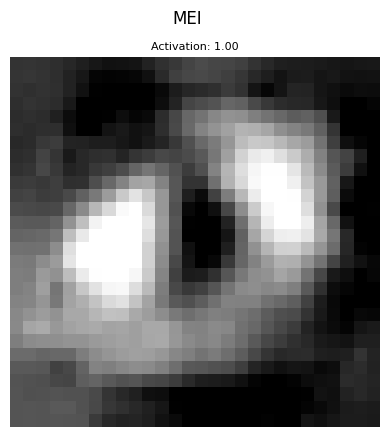

In [4]:
meip = Mei.generate(0,
                    iter_n=1000,           # number of iterations
                    start_sigma=1.5,
                    end_sigma=0.01,
                    start_step_size=3.0,
                    end_step_size=0.125,
                    precond=0,            # strength of gradient preconditioning filter falloff
                    step_gain=0.1,        # scaling of gradient steps
                    jitter=0,             #size of translational jittering
                    blur=True,
                    norm=-1,              # norm adjustment after step, negative to turn off
                    train_norm=-1,        # norm adjustment during step, negative to turn off
                    clip=True)            # Whether to clip the range of the image to be in valid range
show_image(meip.image[0], text="MEI", activation=meip.activation)

In [5]:
#list neuron query for multiple dimension output
meip_complex = Mei.generate([2]) # for 2 dimensions would be [0,1] for example

#no neuron query to generate for all neurons
meip_all = Mei.generate()

#custom neuron query
meip_custom = Mei.generate(lambda index: index[-1]%2==0)

100%|██████████| 1000/1000 [00:00<00:00, 8488.74it/s]


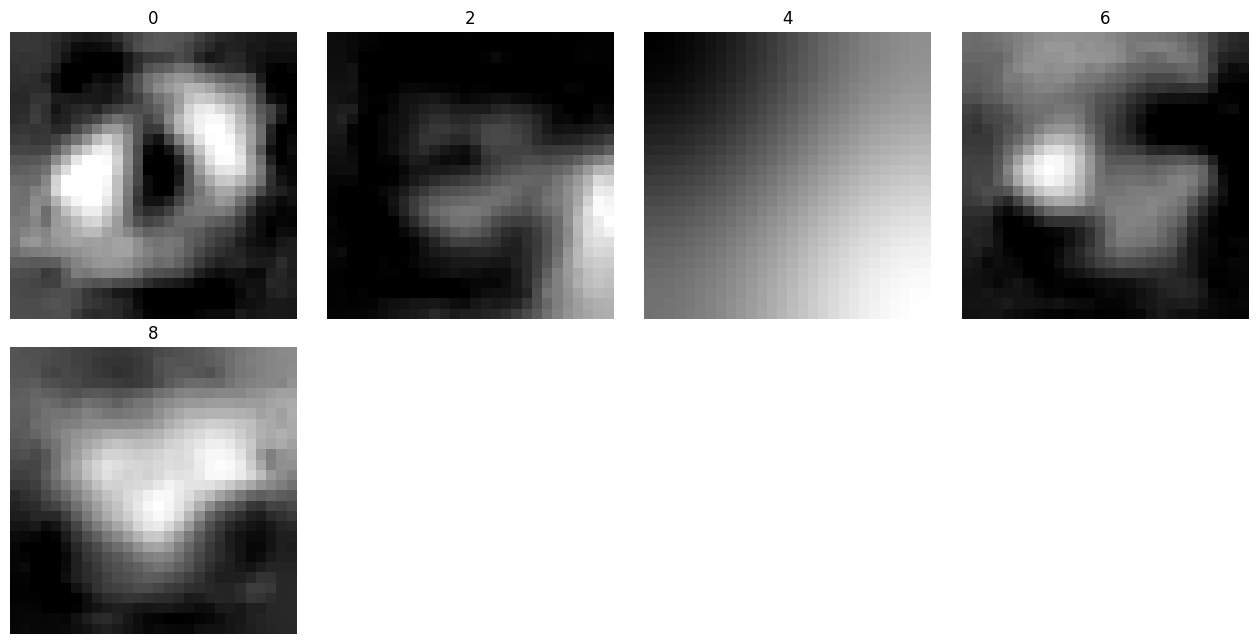

In [6]:
show_image_grid(
    [m.image[0] for m in meip_custom],
    texts=[f"{i}" for i in range(0, 10, 2)],
    activations=[m.activation for m in meip_custom])

# Generate gradient receptive field

100%|██████████| 1/1 [00:00<00:00, 1190.21it/s]


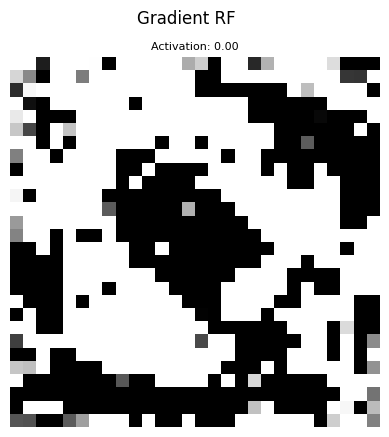

In [16]:
gradrf = Mei.gradient_rf(0,
                         iter_n=1000,
                         start_sigma=1.5,
                         end_sigma=0.01,
                         start_step_size=3.0,
                         end_step_size=0.125,
                         precond=0,
                         step_gain=0.1,
                         jitter=0,
                         blur=True,
                         norm=-1,
                         train_norm=-1,
                         clip=True)
show_image(gradrf.image[0], text="Gradient RF", activation=gradrf.activation)

# Find most excitatory samples from dataset

100%|██████████| 60000/60000 [00:09<00:00, 6524.77it/s]


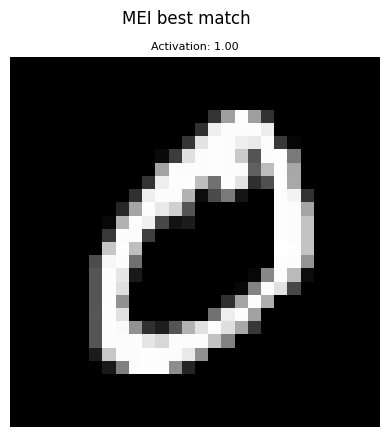

In [9]:
meip_best_match_activation, meip_best_match_image = meip.best_match(model1.train_loader)
show_image(meip_best_match_image, text="MEI best match", activation=meip_best_match_activation)

# Compare original and *masked/shifted* responses

100%|██████████| 1/1 [00:00<00:00, 447.01it/s]


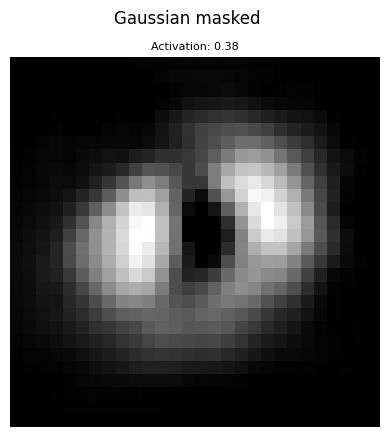

In [6]:
# Gaussian mask

gaussian_masked_resp, gaussian_masked_image = meip.masked_responses(mask="gaussian", factor=3)
show_image(gaussian_masked_image[0], text="Gaussian masked", activation=gaussian_masked_resp)

100%|██████████| 1/1 [00:00<00:00, 332.43it/s]


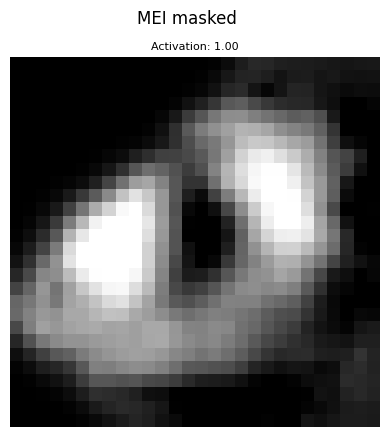

In [7]:
# MEI mask

mei_masked_resp, mei_masked_image = \
    meip.masked_responses(mask="mei",
                         delta_thr=0.2,     # threshold on the difference from mean
                         size_thr=80,       # threshold for size of blobs
                         expansion_sigma=1, # mask size expansion sigma
                         expansion_thr=0.3, # mask size expansion threshold
                         filter_sigma=1)    # sigma for final gaussian blur
show_image(mei_masked_image[0], text="MEI masked", activation=mei_masked_resp)

100%|██████████| 1/1 [00:00<00:00, 246.80it/s]


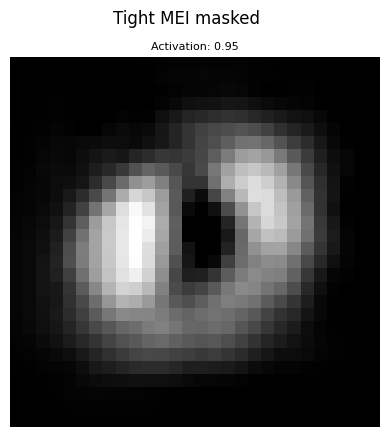

In [21]:
# Tight MEI mask

t_mei_masked_resp, t_mei_masked_image = \
    meip.masked_responses(mask="mei_tight",
                          stdev_size_thr=1,           #fraction of standard dev threshold for size of blobs
                          filter_sigma=3,             #sigma for final gaussian blur
                          target_reduction_ratio=0.99) #reduction ratio to achieve for tightening the mask
show_image(t_mei_masked_image[0], text="Tight MEI masked", activation=t_mei_masked_resp)

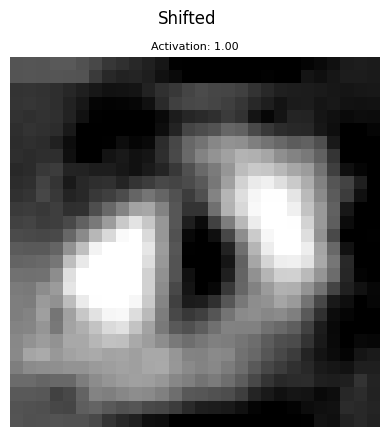

In [12]:
# Shifted

shifted_resp, shifted_image = meip.shifted_response(x_shift=2, y_shift=3)
show_image(shifted_image[0], text="Shifted", activation=shifted_resp)

# Create Gabor stimuli and find most excitatory ones

In [13]:
gabor = mei.Gabor(models=[model1, model2], shape=(1, 28, 28))

Creating gabors


72800it [01:32, 787.73it/s]


Evaluating gabors


72800it [00:06, 11195.63it/s]


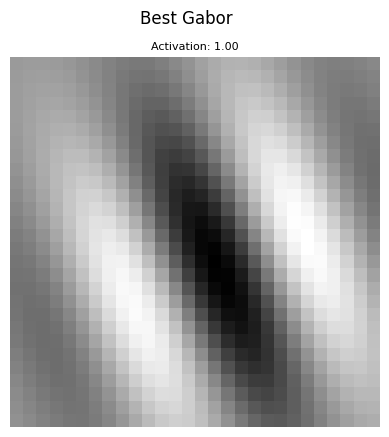

In [14]:
best_gabor = gabor.best_gabor(0)
show_image(best_gabor.image, text="Best Gabor", activation=best_gabor.activation)

# Find optimal Gabor stimuli

100%|██████████| 5/5 [00:27<00:00,  5.40s/it]


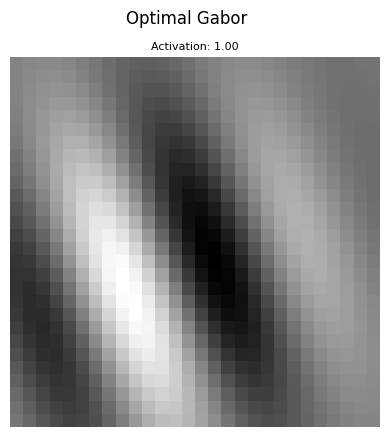

In [15]:
optimal_gabor = gabor.optimal_gabor(0)
show_image(optimal_gabor.image, text="Optimal Gabor", activation=optimal_gabor.activation)

# Compute spatial frequency

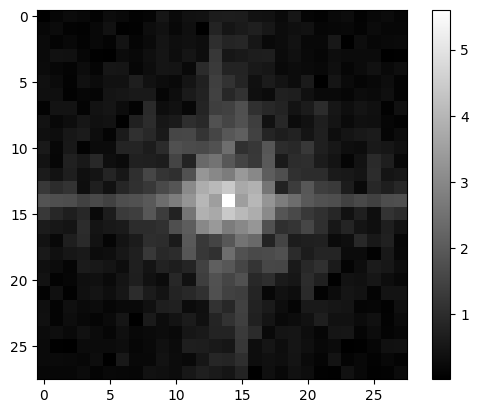

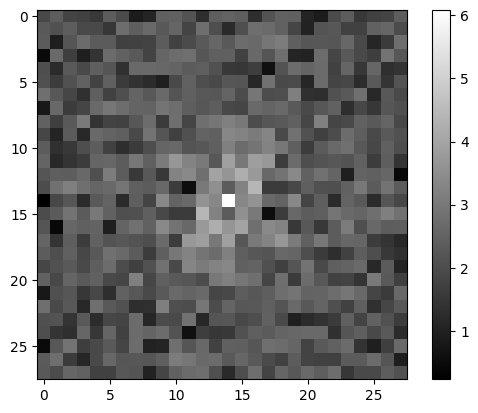

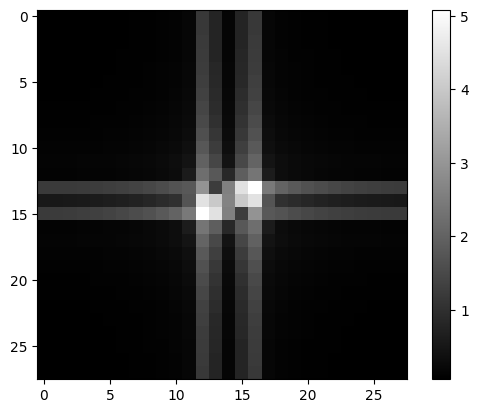

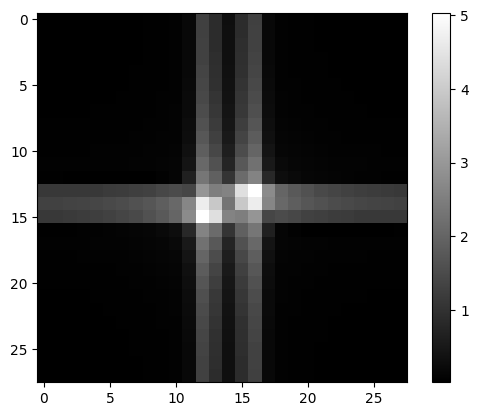

In [18]:
freq_cols_mei, freq_rows_mei, magnitude_spectrum_mei = meip.spatial_frequency()

freq_cols_gradrf, freq_rows_gradrf, magnitude_spectrum_gradrf = gradrf.spatial_frequency()

freq_cols_best_gabor, freq_rows_best_gabor, magnitude_spectrum_best_gabor = best_gabor.spatial_frequency()

freq_cols_optimal_gabor, freq_rows_optimal_gabor, magnitude_spectrum_optimal_gabor = optimal_gabor.spatial_frequency()